In [26]:
using Revise

In [27]:
using Distributed
n_procs = 2
if n_procs > nprocs()
    addprocs(n_procs - nprocs())
end
;

In [28]:
@everywhere using QuantumStates, UnitsToValue
using Plots, LaTeXStrings

In [29]:
@everywhere begin
    H_X_v0 = load_from_file("CaF_X_v0", ".\\CaF_structure\\")
    H_A_v0 = load_from_file("CaF_A_v0", ".\\CaF_structure\\")
    H_B_v0 = load_from_file("CaF_B_v0", ".\\CaF_structure\\")

    N_max = 3

    # reduce rotational state space
    H_X_v0 = subspace(H_X_v0, (N=0:N_max,))
    H_A_v0 = subspace(H_A_v0, (J=1/2:(N_max+3/2),))
    H_B_v0 = subspace(H_B_v0, (N=0:(N_max+1),))
end
;

In [30]:
@everywhere begin
    QN_bounds = (
        label = "A",
        I = 1/2,
        S = 1/2,
        Λ = (-1,+1),
        N = 1:(N_max+2),
        J = 1/2:(N_max+3/2),
        v = 0
    )
    A_state_caseB_basis = order_basis_by_m(enumerate_states(HundsCaseB_Rot, QN_bounds))

    H_A_v0_caseB = convert_basis(H_A_v0, A_state_caseB_basis)
    evaluate!(H_A_v0_caseB)
    solve!(H_A_v0_caseB)
end

In [31]:
@everywhere begin 
    # w = 1e-6
    # P = 20e-3
    
    w = 0.91e-6
    P = 38e-3

    I0_trap = 2P / (π * w^2)
    # I0_trap = 1e9

    d_egAX = 5.95 * Debye
    d_egBX = 4.70 * Debye

    (d_egAX, d_egBX) |> display
end

(1.984706395e-29, 1.56775127e-29)

      From worker 2:	(1.984706395e-29, 1.56775127e-29)


In [32]:
@everywhere begin
    Hs = [H_X_v0, H_A_v0_caseB, H_B_v0]
    H = CombinedHamiltonian(Hs)

    x = [1.0, 0.0, -1.0] / √2
    y = im * [1.0, 0.0, 1.0] / √2
    z = [0.0, 1.0, 0.0]
    
    # linearly polarized trap
    θ = 0
    ϵ = cos(θ) * z + sin(θ) * x
    
    # X-A operator
    XA(q) = (state, state′) -> (d_egAX / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "A")
    XA_conj(q) = (state, state′) -> conj(XA(q)(state′, state))
    
    # X-B operator
    XB(q) = (state, state′) -> (d_egBX / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "B")
    XB_conj(q) = (state, state′) -> conj(XB(q)(state′, state))

    q = 1; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + XA_conj(q-2) + XB_conj(q-2)
    )
    q = 2; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + XA_conj(q-2) + XB_conj(q-2)
    )
    q = 3; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + XA_conj(q-2) + XB_conj(q-2)
    )

    evaluate!(H)
    solve!(H)
end

### State energies versus trap intensity

In [33]:
@everywhere function H_func_neg!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(scan_values[1] / (2ε0 * c)) # should it be sqrt(scan_Values[1] / (2 * ε0 * c))?
    H.parameters.E_trap2 = ϵ[2] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(scan_values[1] / (2ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 526e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] -= trap_frequency
    end    
    solve!(H)
    
    return nothing
end
@everywhere function H_func_pos!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap2 = ϵ[2] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(scan_values[1] / (2ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 526e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] += trap_frequency
    end    
    solve!(H)
    
    return nothing
end
;

In [34]:
Is = (0:0.015:1) .* I0_trap * 0.05
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values_neg, _ = scan_parameters_v2(H, scan_params, iterator, H_func_neg!, H -> energy.(H.states))
matrix_values_neg = hcat(values(scan_values_neg)...)'
@time scan_values_pos, _ = scan_parameters_v2(H, scan_params, iterator, H_func_pos!, H -> energy.(H.states))
matrix_values_pos = hcat(values(scan_values_pos)...)'

matrix_values = matrix_values_neg .+ matrix_values_pos
Es_rel = matrix_values .- matrix_values[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.247559 seconds (153.88 k allocations: 18.378 MiB, 0.13% gc time, 1 lock conflict, 1.03% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.456391 seconds (154.55 k allocations: 18.440 MiB, 0.15% gc time, 1.28% compilation time)


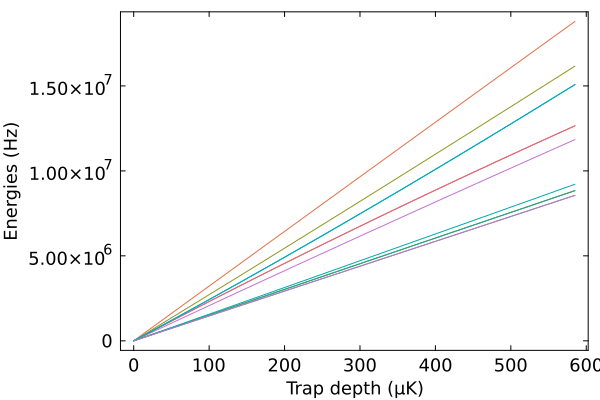

In [35]:
using Plots, LaTeXStrings
trap_depths = abs.((1e6 * h / kB) .* Es_rel)
plot(trap_depths[:,1], Es_rel[:,5:16])

plot!(
    xlabel="Trap depth (μK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )

# Solve Hamiltonian in the presence of trap

In [36]:
H.parameters.E_trap1 = 0ϵ[1] * sqrt(2I0_trap / (ε0 * c)) # no trap, bare hamiltonian
H.parameters.E_trap2 = 0ϵ[2] * sqrt(2I0_trap / (ε0 * c))
H.parameters.E_trap3 = 0ϵ[3] * sqrt(2I0_trap / (ε0 * c))

evaluate!(H)
solve!(H)

ground_state_idxs = 5:16
excited_state_idxs = 69:72
states_idxs = [ground_state_idxs; excited_state_idxs]

states_cooling_sim = H.states[states_idxs]
;

In [37]:
# using Serialization
# serialize("states_cooling_sim_tweezer.jl", states_cooling_sim)
# ;

# Create effective Hamiltonian in laser cooling subspace

In [38]:
@everywhere function create_effective_hamiltonian(g_idxs, e_idxs, H, H_matrix, f_ODT)

    n = length(g_idxs)
    H_eff = zeros(ComplexF64, n, n)

    for _i ∈ 1:n
        for _j ∈ 1:n
            for k ∈ e_idxs
                i = g_idxs[_i]
                j = g_idxs[_j]
                E_ground = energy(H.states[i])
                E_excited = energy(H.states[k])
                H_eff[_i,_j] -= H_matrix[i,k] * H_matrix[j,k] / (E_excited - E_ground - f_ODT)
                H_eff[_i,_j] -= H_matrix[k,i] * H_matrix[k,j] / (E_excited - E_ground + f_ODT)
            end
        end
    end

    return H_eff
end
;

In [39]:
@everywhere begin
    H_ODT_matrix = ϵ[1] .* H.operators.E_trap1.matrix .+ ϵ[2] .* H.operators.E_trap2.matrix .+ ϵ[3] .* H.operators.E_trap3.matrix

    X_idxs, _ = subspace(H.basis, (label=["X"],))
    A_idxs, _ = subspace(H.basis, (label=["A"],))
    B_idxs, _ = subspace(H.basis, (label=["B"],))

    X_N1_idxs, _ = subspace(H.basis, (label=["X"], N=[1],))
    A_J12_idxs, _ = subspace(H.basis, (label=["A"], J=[1/2],))
    
    const H_ODT_eff_g = create_effective_hamiltonian(X_N1_idxs, [A_idxs..., B_idxs...], H, H_ODT_matrix, c/526e-9)
    const H_ODT_eff_e = create_effective_hamiltonian(A_J12_idxs, [], H, H_ODT_matrix, c/526e-9)
end
;

      From worker 2:	WARNING: redefinition of constant Main.H_ODT_eff_g. This may fail, cause incorrect answers, or produce other errors.
      From worker 2:	WARNING: redefinition of constant Main.H_ODT_eff_e. This may fail, cause incorrect answers, or produce other errors.


In [40]:
@everywhere begin
    HX_eff = subspace(deepcopy(H_X_v0), (N=1,))
    # evaluate!(HX_eff)
    # solve!(HX_eff)

    HA_eff = subspace(deepcopy(H_A_v0_caseB), (J=1/2,))
    # evaluate!(HA_eff)
    # solve!(HA_eff)
end
;

In [41]:
@everywhere begin
    H_ODT_matrix_g = create_matrix_for_states(H_ODT_eff_g, HX_eff.states)
    H_ODT_matrix_e = create_matrix_for_states(H_ODT_eff_e, HA_eff.states)
end
;

In [42]:
H_ODT_matrix = zeros(ComplexF64, 16, 16)
H_ODT_matrix[1:12, 1:12] .= H_ODT_matrix_g[1:12, 1:12]
H_ODT_matrix[13:16, 13:16] .= H_ODT_matrix_e[5:8, 5:8]
;

In [43]:
H_ODT_matrix[13:16,13:16]

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

3.242715481337125e-5 + 0.0im

0.0 + 0.0im

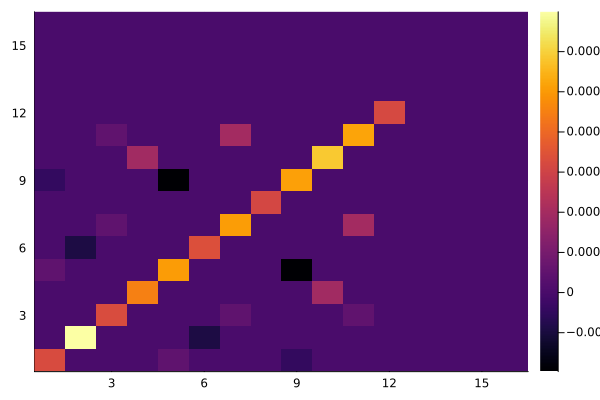

In [44]:
H_ODT_matrix[1,1] |> display
H_ODT_matrix[end, end] |> display

# tensor_stark_shift = deepcopy(H_ODT_matrix[1:12, 1:12])
# scalar_stark_shift = tensor_stark_shift[1,1]
# for idx in 1:12
#     tensor_stark_shift[idx,idx] -= scalar_stark_shift
# end

# real(tensor_stark_shift) |> heatmap
real(H_ODT_matrix) |> heatmap

In [45]:
using Serialization
serialize("H_axial_lattice_matrix.jl", H_ODT_matrix)
;

## Let's check the trap shifts versus energy for the effective Hamiltonian for $X(N=1)$

In [46]:
@everywhere function H_func!(H, scan_values)
    evaluate!(H)
    H.matrix .+= sqrt(scan_values[1] / (2ε0 * c))^2 .* H_ODT_eff_g
    solve!(H)
    return nothing
end
;

In [47]:
Is = (0:0.015:1) .* I0_trap
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values, _ = scan_parameters_v2(HX_eff, scan_params, iterator, H_func!, H -> energy.(H.states))
energies = hcat(values(scan_values)...)'
energies_relative = energies .- energies[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.360094 seconds (84.84 k allocations: 4.395 MiB, 24.11% compilation time)


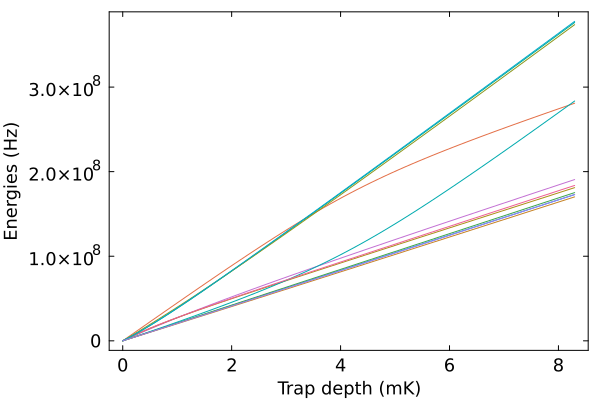

In [48]:
using Plots, LaTeXStrings
trap_depths = abs.((1e3 * h / kB) .* energies_relative)
plot(trap_depths[:,1], energies_relative[:,:])

plot!(
    xlabel="Trap depth (mK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )

In [49]:
H_g = sqrt(I0_trap / (2ε0 * c))^2 .* H_ODT_eff_g

12×12 Matrix{ComplexF64}:
 1.71906e8+0.0im        0.0+0.0im  …         0.0+0.0im        0.0+0.0im
       0.0+0.0im  2.46594e8+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im  5.25306e7+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im  9.01598e7+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im  …         0.0+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im            0.0+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im     -9.02997e7+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im     -6.38516e7+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im  …   2.85086e8+0.0im        0.0+0.0im
       0.0+0.0im        0.0+0.0im            0.0+0.0im  1.74755e8+0.0im